## Evil Geniuses - DS Intern Assessment
__Name:__ Runqing (Roch) Jia

__Creation Date:__ May 24, 2023

__Last Modified Date:__ May 25, 2023

In [948]:
# Import essenstial libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm

In [949]:
# Import the data
df = pd.read_csv('data/starcraft_player_data.csv')

### 1. EDA & Data Cleansing

Our initial undertaking involves understanding the data, a task which can be divided into two sections:

__1)__ Extracting profile information of the data: This step focuses on understanding the users our data represents.

__2)__ Exploring the data from a management perspective: Our aim here is to identify any potential issues with the data and resolve them through data cleansing. This will ensure the data is primed for the modeling process.

#### 1.1 Overall Exploration

The dataset comprises ~3400 rows of data, with each row representing the information of one unique user (identified by __GameID__). The data incorporates features about users' personal profiles, degree of engagement, and gaming behaviors. The objective is to predict the rank of the user, stored in the __'LeagueIndex'__ column - __'LeagueIndex'__ is our target variable.

The data appears to be clean, with no obvious missing values. Nevertheless, we discovered that the __'Age'__, __'HoursPerWeek'__, and __'TotalHours'__ columns have the data type 'object', which suggests that there might be some records with a data type other than integer, which warrants further investigation in our subsequent analysis.

We can gain a quick snapshot of our dataset, its structure, any missing values, and the data types of our columns with the following code:

In [950]:
# Overview of the dataset
df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [951]:
# Data Structure
df.shape

(3395, 20)

In [952]:
# Check missing value
df.isna().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

In [953]:
# Check data types
df.dtypes

GameID                    int64
LeagueIndex               int64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

#### 1.2 Exploration & Visualization by Column
Our focus in this segment is on the users' profile, with the aim of gaining a better understanding of the gamer group. We intend to utilize data visualization tools to facilitate a deeper understanding of the distribution of our target columns.

##### 1.2.1 Target Variable: LeagueIndex
Our first objective is to understand the distribution of rankings. We find that the distribution is almost normally distributed but demonstrates slight __right skewness__. Generally, most players fall within the Platinum and Diamond categories, with relatively fewer players in the GrandMaster and Professional tiers.

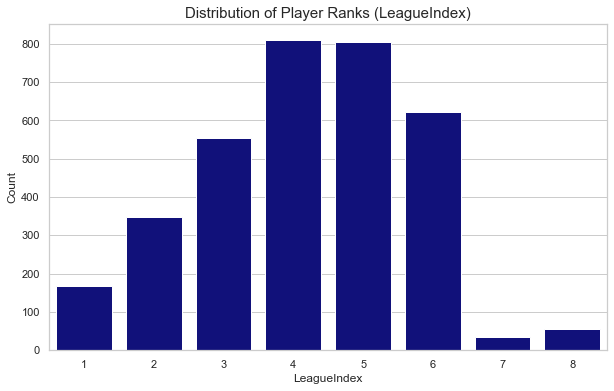

In [954]:
# Viz: Distribution of League Rank
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=df, x='LeagueIndex', color='darkblue', ax=ax)
ax.set_title('Distribution of Player Ranks (LeagueIndex)', fontsize=15)
ax.set_xlabel('LeagueIndex', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

plt.show()

##### 1.2.2 Age
__Age__ is one of the key personal characteristics within the dataset. An initial review of unique values reveals a challenge: beyond the expected range of integer values, the value __"?"__ is also present in this column, which represents an unknown record - a missing value. There are 55 instances of "?" in the "Age" column.

We address this issue by converting "?" to NaN and standardizing the data to a numeric format. For visualization of age distribution, we categorize ages into four groups: Under 18, 18-30, Over 30, and Unknown. The resulting distribution reveals that the majority of gamers in this dataset are in their young adulthood, with a relatively small proportion of middle-aged users.

In [955]:
# Check the unique values
df['Age'].unique()

array(['27', '23', '30', '19', '32', '21', '17', '20', '18', '16', '26',
       '38', '28', '25', '22', '29', '24', '35', '31', '33', '37', '40',
       '34', '43', '41', '36', '44', '39', '?'], dtype=object)

In [956]:
# Check the number of records with "?"
df['Age'].value_counts()['?']

55

In [957]:
# Datatype conversion
# Convert the '?' to a NaN value for easier manipulation
df['Age'] = df['Age'].replace('?', np.nan)
# Convert the column to numeric
df['Age'] = pd.to_numeric(df['Age'])

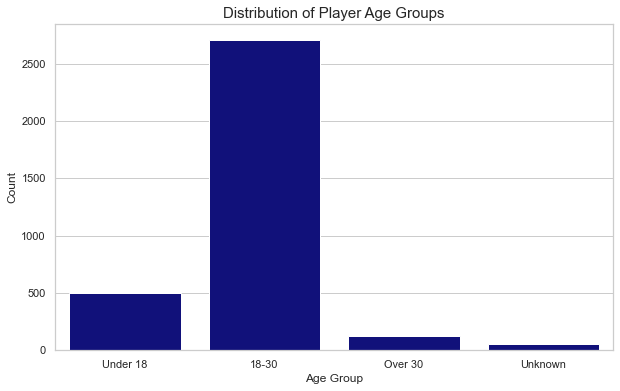

In [958]:
# Viz: Distribution of Age
# Define a function to categorize ages
def categorize_age(age):
    if age < 18:
        return 'Under 18'
    elif 18 <= age <= 30:
        return '18-30'
    elif age > 30:
        return 'Over 30'
    else:
        return 'Unknown'

# Apply the function to the Age column
df['AgeGroup'] = df['Age'].apply(categorize_age)

# Viz
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='AgeGroup', order=['Under 18', '18-30', 'Over 30', 'Unknown'], color='darkblue')
plt.title('Distribution of Player Age Groups', fontsize=15)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


##### 1.2.3 HoursPerWeek
Next, we examine the __HoursPerWeek__ column, where we encounter the same issue of "?" values. We apply the same strategy to handle this, converting "?" to NaN and adjusting the data type. This column contains 56 instances of missing data.

We also visualize the distribution of HoursPerWeek by creating categories to represent different player engagement levels: Under 10 (Casual Gamer), 10-20 (Medium Gamer), 20-50 (Addictive Gamer), Over 50 (Super Addictive Gamer), and Unknown. The visualization shows that the majority of players are casual or medium gamers, which aligns with general expectations.

In [959]:
df['HoursPerWeek'].unique()

array(['10', '20', '6', '8', '42', '14', '24', '16', '4', '12', '30',
       '28', '70', '2', '56', '36', '40', '18', '96', '50', '168', '48',
       '84', '0', '72', '112', '90', '32', '98', '140', '?', '80', '60'],
      dtype=object)

In [960]:
df['HoursPerWeek'].value_counts()['?']

56

In [961]:
df['HoursPerWeek'] = df['HoursPerWeek'].replace('?', np.nan)
df['HoursPerWeek'] = pd.to_numeric(df['HoursPerWeek'])

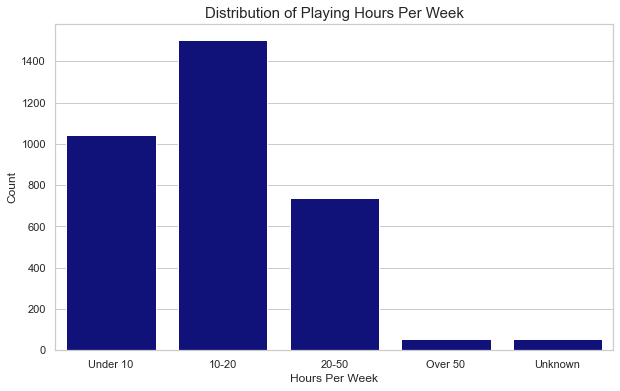

In [962]:
# Viz: Distribution of HoursPerWeek
# Define a function to categorize HPW
def categorize_HPW(HoursPerWeek):
    if HoursPerWeek < 10:
        return 'Under 10'
    elif 10 <= HoursPerWeek <= 20:
        return '10-20'
    elif 20 < HoursPerWeek <= 50:
        return '20-50'
    elif HoursPerWeek > 50:
        return 'Over 50'
    else:
        return 'Unknown'

# Apply the function to the Age column
df['HPWGroup'] = df['HoursPerWeek'].apply(categorize_HPW)

# Viz
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='HPWGroup', order=['Under 10', '10-20', '20-50', 'Over 50', 'Unknown'], color='darkblue')
plt.title('Distribution of Playing Hours Per Week', fontsize=15)
plt.xlabel('Hours Per Week', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

##### 1.2.4 TotalHours
We again encounter the "?" value problem in the __TotalHours__ column, and address it using the same data cleaning approach.

For visualizing TotalHours, we use different intervals to categorize player engagement: Under 200, 200-1000, 1000-5000, Over 5000, and Unknown. The resulting distribution shows most players have logged between 200 and 1000 hours, a reasonable range for casual and medium gamers. A very small proportion of players are heavily invested in the game, with over 5000 hours logged.

In [963]:
df['TotalHours'].unique()

array(['3000', '5000', '200', '400', '500', '70', '240', '10000', '2708',
       '800', '6000', '190', '350', '1000', '1500', '2000', '120', '1100',
       '2520', '700', '160', '150', '250', '730', '230', '300', '100',
       '270', '1200', '30', '600', '540', '280', '1600', '50', '140',
       '900', '550', '625', '1300', '450', '750', '612', '180', '770',
       '720', '415', '1800', '2200', '480', '430', '639', '360', '1250',
       '365', '650', '233', '416', '1825', '780', '1260', '315', '10',
       '312', '110', '1700', '92', '2500', '1400', '220', '999', '303',
       '96', '184', '4000', '420', '60', '2400', '2160', '80', '25',
       '624', '176', '?', '35', '1163', '333', '75', '7', '40', '325',
       '90', '175', '88', '850', '26', '1650', '465', '235', '1350',
       '460', '848', '256', '130', '1466', '670', '711', '1030', '1080',
       '1460', '1050', '20000', '582', '2800', '553', '1008', '330',
       '936', '243', '1320', '425', '1145', '366', '2700', '830', '3',
 

In [964]:
df['TotalHours'].value_counts()['?']

57

In [965]:
df['TotalHours'] = df['TotalHours'].replace('?', np.nan)
df['TotalHours'] = pd.to_numeric(df['TotalHours'])

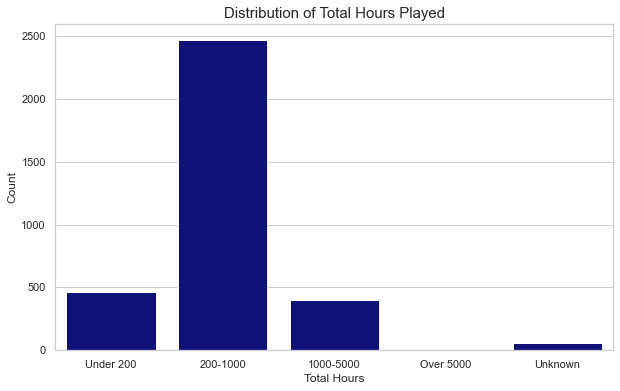

In [966]:
# Viz: Distribution of TotalHours
# Define a function to categorize TotalHours
def categorize_TH(TotalHours):
    if TotalHours < 200:
        return 'Under 200'
    elif 200 <= TotalHours <= 1000:
        return '200-1000'
    elif 1000 < TotalHours <= 5000:
        return '1000-5000'
    elif TotalHours > 5000:
        return 'Over 5000'
    else:
        return 'Unknown'

# Apply the function to the Age column
df['THGroup'] = df['TotalHours'].apply(categorize_TH)

# Viz
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='THGroup', order=['Under 200', '200-1000', '1000-5000', 'Over 5000', 'Unknown'], color='darkblue')
plt.title('Distribution of Total Hours Played', fontsize=15)
plt.xlabel('Total Hours', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

#### 1.3 Data Cleansing

##### 1.3.1 Drop Columns
Dropping irrelevant columns is a common step in data preprocessing for ML applications. 

The 'GameID' column was dropped, as it is a unique identifier for each game and does not provide any statistically meaningful information. Moreover, intermediate features generated for EDA are also dropped, which are not useful for model training.

In [ ]:
# Game ID is just an index without statistical value; drop it first
df = df.drop('GameID', axis = 1)
# Drop the intermediate columns for viz
df = df.drop(['AgeGroup', 'HPWGroup', 'THGroup'], axis = 1)

##### 1.3.2 Manipulation on Missing Values
The next step is handling missing values. It appears that there are only 57 records with missing values across the 'Age', 'HoursPerWeek', and 'TotalHours' columns. Interestingly, 55 of these records have all three fields missing, and all the 55 records belong to Professional (Rank 8).

Given that there are exactly 55 players at Professional rank, it was decided not to remove these records, since removing could potentially lead to a bias in the data. Instead, a model-based imputation approach was used. This involves using other features to predict and fill in the missing values with linear regression in this case.

In [968]:
# Have an overview of the records with missing values
df[(df['Age'].isnull()) | (df['HoursPerWeek'].isnull()) | (df['TotalHours'].isnull())]

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
358,5,17.0,20.0,NaN,94.4724,0.003846,0.000783,3,0.000010,0.000135,0.004474,50.5455,54.9287,3.0972,31,0.000763,7,0.000106,0.000116
1841,5,18.0,NaN,NaN,122.2470,0.006357,0.000433,3,0.000014,0.000257,0.003043,30.8929,62.2933,5.3822,23,0.001055,5,0.000000,0.000338
3340,8,NaN,NaN,NaN,189.7404,0.004582,0.000655,4,0.000073,0.000618,0.006291,23.5130,32.5665,4.4451,25,0.002218,6,0.000000,0.000000
3341,8,NaN,NaN,NaN,287.8128,0.029040,0.001041,9,0.000231,0.000656,0.005399,31.6416,36.1143,4.5893,34,0.001138,6,0.000058,0.000000
3342,8,NaN,NaN,NaN,294.0996,0.029640,0.001076,6,0.000302,0.002374,0.006294,16.6393,36.8192,4.1850,26,0.000987,6,0.000000,0.000000
3343,8,NaN,NaN,NaN,274.2552,0.018121,0.001264,8,0.000053,0.000975,0.007111,10.6419,24.3556,4.3870,28,0.001106,6,0.000000,0.000000
3344,8,NaN,NaN,NaN,274.3404,0.023131,0.000739,8,0.000622,0.003552,0.005355,19.1568,36.3098,5.2811,28,0.000739,6,0.000000,0.000000
3345,8,NaN,NaN,NaN,245.8188,0.010471,0.000841,10,0.000657,0.001314,0.005031,14.5518,36.7134,7.1943,33,0.001474,11,0.000040,0.000048
3346,8,NaN,NaN,NaN,211.0722,0.013049,0.000940,10,0.000366,0.000909,0.003719,19.6169,38.9326,7.1320,23,0.000898,9,0.000000,0.000000
3347,8,NaN,NaN,NaN,189.5778,0.007559,0.000487,10,0.000606,0.000566,0.005821,22.0317,36.7330,4.9050,28,0.000540,5,0.000000,0.000000


In [969]:
# Check the count of Rank 8 (Professional) - Turns out that all the players in Rank 8 have missing values in the 3 features
df[df['LeagueIndex'] == 8]['LeagueIndex'].count()

55

In [970]:
# Missing value manipulation:
# Create a function to apply model-based imputation
def model_based_imputation(df, col, features):
    # Split the missing part and known part
    missing_data = df[df[col].isnull()]
    known_data = df[df[col].notnull()]
    # Apply the linear model & Predict
    model = LinearRegression()
    model.fit(known_data[features], known_data[col])
    pred = model.predict(missing_data[features])
    # Filter the missing values and replace them with the predicted values
    df.loc[df[col].isnull(), col] = pred

    return df

In [971]:
cols = ['Age', 'HoursPerWeek', 'TotalHours']
all_cols = [col for col in df.columns.to_list() if col != 'LeagueIndex']
features = [col for col in all_cols if col not in cols]
for col in cols:
    df = model_based_imputation(df, col, features)
    # Convert the data type into integer
    df[col] = df[col].astype(int)

##### 1.3.3 Exclude Outliers
Following the imputation, our dataset is clean, but outliers remain a concern. We noticed several issues through a statistical summary:

__1)__ Negative values (predicted) appear in TotalHours. This is illogical, as a time-related attribute cannot have a negative value.

__2)__ Outliers occur in HoursPerWeek and TotalHours. It's impractical for a player to engage in a game for 168 hours (24 * 7) a week without sleep, and a value of 1,000,000 Total Hours is nonsensical - that would suggest the player has been gaming since 1900s.

Although we have recognized these outliers, the rarity and isolated nature of these cases mean that their removal will not greatly impact our dataset. Consequently, we will drop these outlier rows. This leaves us with 3,329 rows, each with 18 features and 1 target variable.

In [972]:
# Check the statistical summary of each column
df.describe()

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000
mean,4.184094,21.610604,16.070103,1047.200884,117.046947,0.004299,0.000374,4.364654,0.000098,0.000387,0.003463,40.361562,63.739403,5.272988,22.131664,0.001032,6.534021,0.000059,0.000142
std,1.517327,4.185772,11.938253,17188.730209,51.945291,0.005284,0.000225,2.360333,0.000166,0.000377,0.000992,17.153570,19.238869,1.494835,7.431719,0.000519,1.857697,0.000111,0.000265
min,1.000000,16.000000,0.000000,-1065.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.093600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,3.000000,19.000000,8.000000,300.000000,79.900200,0.001258,0.000204,3.000000,0.000000,0.000140,0.002754,28.957750,50.446600,4.272850,17.000000,0.000683,5.000000,0.000000,0.000000
50%,4.000000,21.000000,12.000000,500.000000,108.010200,0.002500,0.000353,4.000000,0.000040,0.000281,0.003395,36.723500,60.931800,5.095500,22.000000,0.000905,6.000000,0.000000,0.000020
75%,5.000000,24.000000,20.000000,800.000000,142.790400,0.005133,0.000499,6.000000,0.000119,0.000514,0.004027,48.290500,73.681300,6.033600,27.000000,0.001259,8.000000,0.000086,0.000181
max,8.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001752,10.000000,0.003019,0.004041,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


In [973]:
# Drop the rows with negative predicted values since it does not make sense
df = df.drop((df[(df['HoursPerWeek'] < 0) | (df['TotalHours'] < 0)]).index)
# Drop the rows with extreme values in HoursPerWeek and TotalHours
df = df.drop(df[df['HoursPerWeek'] == 168].index)
df = df.drop(df[df['TotalHours'] == 1000000].index)

In [974]:
# Check the data structure after manipulation
df.shape

(3392, 19)

### 3. Feature Selection
At this stage, we intend to explore the correlations and relative importance of all features. We will use two techniques: a Correlation Heatmap and Lasso Regression.

Although the correlation heatmap indicates risks of multicollinearity due to high correlation values, we opt to keep all features considering the limited size of our dataset and the unique information each column provides. Further potential improvements may be feature engineering.

#### 3.1 Correlation Heatmap

Text(0.5, 1.0, 'Correlation Heatmap')

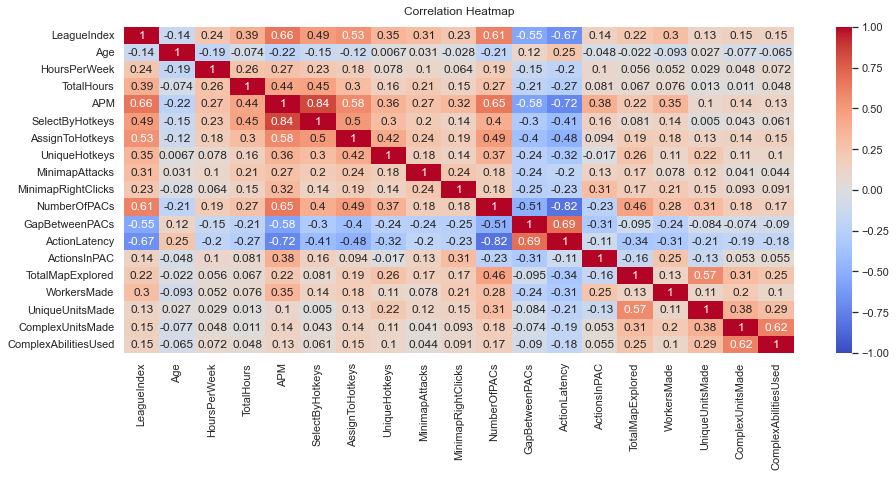

In [975]:
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

#### 3.2 Lasso Regression
The Lasso Regression feature importance plot suggests that 'MinimapRightClicks' and 'APM' are the least important features. Nonetheless, considering our data's limited size, we decide to proceed without removing any columns. Feature engineering may be applied in future work to further optimize our dataset.

In [976]:
#  Lasso
X = df.drop('LeagueIndex', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = df['LeagueIndex']

In [977]:
# Create a LassoCV object to find the best alpha
lasso_cv = LassoCV(cv=10, random_state=0, max_iter=10000)
# Fit it to the scaled data
lasso_cv.fit(X_scaled, y)
print('Best alpha:', round(lasso_cv.alpha_, 4))

Best alpha: 0.0033


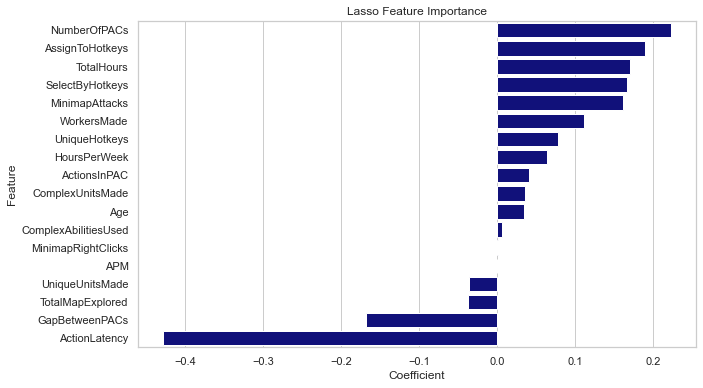

In [978]:
lasso = Lasso(alpha = lasso_cv.alpha_)
lasso.fit(X_scaled, y)
coef = pd.Series(lasso.coef_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=coef, y=coef.index, color='darkblue')
plt.title("Lasso Feature Importance")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()

### 4. Modeling & Deployment
In this phase, we aim to predict player ranks represented by the column 'LeagueIndex', which ranges from 1 (Bronze, the lowest) to 8 (Professional, the highest). This task can be seen as an "ordinal classification" problem, where the integer target variable symbolizes different levels of performance in StarCraft.

Given the ordinal nature of our target, we will approach this task as a regression problem, with RMSE serving as our primary performance metric. Nevertheless, from a practical perspective, decimal predictions are nonsensical. Therefore, we will round off our results to the nearest integer and use accuracy as our secondary performance metric.

In [979]:
# Preparation:
# Split the dataset
X = df.drop('LeagueIndex', axis=1)
y = df['LeagueIndex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Scale X_train and X_test for better interpretability
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [980]:
# Define functions for modeling, tuning and evaluation
def modeling_evaluation(model, X_train, y_train, X_test, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    # Predict the result
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    # Evaluation by RMSE
    rmse_train = mean_squared_error(y_train, pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, pred_test, squared=False)
    print(f'Training RMSE: {rmse_train:.2f}')
    print(f'Testing RMSE: {rmse_test:.2f}')
    # Evaluation by Accuracy - round the result to integer
    pred_train_rounded = np.round(pred_train)
    pred_test_rounded = np.round(pred_test)
    # Rule: if predicted value < 1, it should be set to 1; if > 8, it should be set to 8
    pred_train_rounded = np.where(pred_train_rounded < 1, 1, pred_train_rounded)
    pred_train_rounded = np.where(pred_train_rounded > 8, 8, pred_train_rounded)
    pred_test_rounded = np.where(pred_test_rounded < 1, 1, pred_test_rounded)
    pred_test_rounded = np.where(pred_test_rounded > 8, 8, pred_test_rounded)
    accuracy_train = np.mean(pred_train_rounded == y_train)
    accuracy_test = np.mean(pred_test_rounded == y_test)
    print(f'Training Accuracy: {accuracy_train:.2f}')
    print(f'Testing Accuracy: {accuracy_test:.2f}')

def tuning(model, param, X, y):
    grid_search = GridSearchCV(model, param, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y)
    # Extract the best model
    return grid_search.best_estimator_

#### 4.1 Modeling & Tuning
We tested and tuned four distinct models to identify the most suitable for deployment:

__1) Linear Regression:__ This is a widely applied model, appreciated for its simplicity and outstanding interpretability.

__2) kNN:__ A simple, non-parametric method that performs well on smaller datasets.

__3) Random Forest:__ An advanced ensemble, tree-based model lauded for its robustness and interpretability.

__4) XGBoost:__ A powerful gradient boosting tree-based model with excellent performance and interpretability.

##### Model 1. Linear Regression

In [981]:
lr = LinearRegression()
modeling_evaluation(lr, X_train, y_train, X_test, y_test)

Training RMSE: 0.96
Testing RMSE: 1.01
Training Accuracy: 0.40
Testing Accuracy: 0.38


##### Model 2. kNN

In [982]:
knn = KNeighborsRegressor()
param = {
    'n_neighbors': [5, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_best = tuning(knn, param, X_train_scaled, y_train)
modeling_evaluation(knn_best, X_train_scaled, y_train, X_test_scaled, y_test)

Training RMSE: 0.00
Testing RMSE: 1.02
Training Accuracy: 1.00
Testing Accuracy: 0.36


##### Model 3. Random Forest Regression

In [983]:
rf = RandomForestRegressor(random_state=0)

# Set up the hyperparameter grid for tuning
param = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_best = tuning(rf, param, X_train, y_train)
modeling_evaluation(rf_best, X_train, y_train, X_test, y_test)

Training RMSE: 0.59
Testing RMSE: 0.96
Training Accuracy: 0.61
Testing Accuracy: 0.38


##### Model 4. XGBoost Regression

In [984]:
xgboost = xgb.XGBRegressor(random_state=0)
param = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_best = tuning(xgboost, param, X_train, y_train)
modeling_evaluation(xgb_best, X_train, y_train, X_test, y_test)

Training RMSE: 0.67
Testing RMSE: 0.96
Training Accuracy: 0.55
Testing Accuracy: 0.38


#### 4.2 Model Evaluation
To select the best model, we combined both __RMSE__ and __accuracy__ as our evaluators. According to the results, the Random Forest model yielded the lowest RMSE, while the Linear Regression, Random Forest, and XGBoost models displayed similar accuracy scores.

Taking into account the outstanding interpretability of Linear Regression, we have decided to select it as our optimal model. 

To aid the selection process, the performance of each model is visually represented in the bar plots below, one for RMSE and the other for Accuracy.

In [985]:
# Create a bar plot for performance viz
def evaluation_viz(evaluator, name, model):
    # Define a function to add annotations to each bar
    def annotate_bars(ax, bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f"{height:.2f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    fig, ax = plt.subplots(figsize=(10, 5))
    xbars = ax.bar(model, evaluator, color='darkblue', edgecolor="none")
    annotate_bars(ax, xbars)
    ax.spines['bottom'].set_visible(False)

    plt.xlabel('Models')
    plt.ylabel(name)
    plt.title(f'{name} Performance Comparison')
    plt.show()

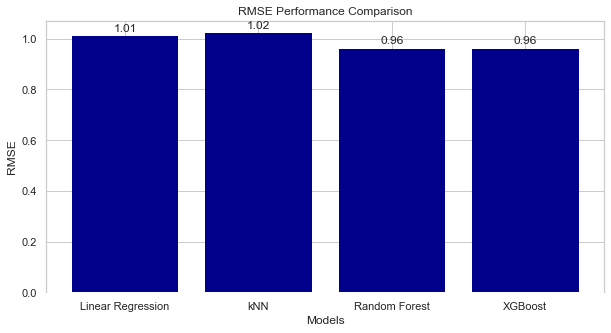

In [986]:
# Viz: RMSE Comparison
rmse = [1.01, 1.02, 0.96, 0.96]
model = ['Linear Regression', 'kNN', 'Random Forest', 'XGBoost']
evaluation_viz(rmse, 'RMSE', model)

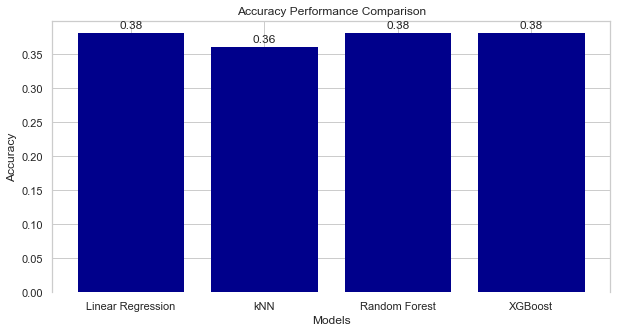

In [987]:
# Viz: Accuracy Comparison
accuracy = [0.38, 0.36, 0.38, 0.38]
evaluation_viz(accuracy, 'Accuracy', model)

#### 4.3 Interpretations

##### 4.3.1 Statistical Summary
Given the statistical result, we can generate some insights:

__1)__ Overall, this model generated __58.8%__ R-Squared, indicating that 58.8% of the variance of LeagueIndex can be explained by our model. Meanwhile, the F-statistic suggested that the predictors of the model are __statistically significant__.

__2)__ __'Age'__ shows a small but positive association with 'LeagueIndex' - older players might have more experience and strategic understanding of the game; __'HoursPerWeek'__ and __'TotalHours'__ are also significantly positive associated - more experienced gamers tend to win more.

__3)__ __'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks', 'NumberOfPACs', 'ActionsInPAC'__ and __'WorkersMade'__ are positively associated, while __'ActionLatency'__ is negatively associated with 'LeagueIndex' - More focusing actions & engagement with quicker response can lead to a higher overall performance.

__4)__ __'TotalMapExplored'__ is negatively related to the rank - seems counterintuitive; could possibly be due to efficient players focusing on key areas rather than exploring the entire map or could be indicative of a different strategy that doesn't require complete map exploration.

__5)__ __'UniqueUnitsMade', 'ComplexAbilitiesUsed'__ and __'ComplexUnitsMade'__ are not statistically significant in prediction - Complicated gameplay strategy does not necessarily lead to advanced rank; the concentration and reaction speed are more crucial than the mere production of unique and complex units.

__6)__ __Multicolinearity__ is still significant - more data, further feature selection & engineering are needed for better interpretability.

In [988]:
X = sm.add_constant(X_train)
model = sm.OLS(y_train, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            LeagueIndex   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     200.2
Date:                Sat, 27 May 2023   Prob (F-statistic):               0.00
Time:                        17:11:33   Log-Likelihood:                -3516.4
No. Observations:                2544   AIC:                             7071.
Df Residuals:                    2525   BIC:                             7182.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.5632 

##### 4.3.2 Feature Importance

__1)__ __'ActionLatency'__ is the most impactful feature - faster responses generally lead to better gameplay

__2)__ __'NumberOfPACs', 'SelectByHotkeys'__ and __'APM'__ are also among the top contributors, highlighting the significance of the player's engagement with the game controls

In [989]:
lr2 = LinearRegression()
lr2.fit(X_train_scaled, y_train)
importance = pd.DataFrame(lr2.coef_, index=X_train.columns, columns=['Coefficient']).Coefficient.abs().sort_values(ascending=False)
importance

ActionLatency           0.417108
NumberOfPACs            0.364661
SelectByHotkeys         0.279588
APM                     0.198596
AssignToHotkeys         0.186140
MinimapAttacks          0.169006
TotalHours              0.160028
GapBetweenPACs          0.144864
ActionsInPAC            0.127712
WorkersMade             0.100904
UniqueHotkeys           0.083008
HoursPerWeek            0.074576
TotalMapExplored        0.071432
UniqueUnitsMade         0.045241
Age                     0.039831
ComplexUnitsMade        0.031516
MinimapRightClicks      0.017747
ComplexAbilitiesUsed    0.010394
Name: Coefficient, dtype: float64

### 5. Key Findings - for Stakeholders

#### Project Overview
Our team was tasked with creating a predictive model to evaluate player performance in StarCraft, with ~3400 rows of data. Using 18 different features related to player behavior and game engagement, we aimed to develop a predictive model that could offer insights into what actions and behaviors led to higher rankings (LeagueIndex).

#### Performance Metrics Summary

__1)__ The model accounts for nearly __59%__ of the variations in player rankings, thereby demonstrating a substantive degree of predictability - our model can offer actionable insights into which factors significantly impact player performance.

__2)__ The model correctly predicts the exact ranks of __~40%__ of players. While there is room for improvement, this level of precision is quite informative in understanding player behaviors that lead to success.

__3)__ The average deviation between our model's predictions and the actual ranks is __~1__ rank. Furthermore, 95% of our predictions land within a span of ±2 ranks of a player's actual ranking, which signifies that our model's predictions are generally close to the actual outcomes.

#### Key Insights
Several significant relationships were found through the model -

__1) Age Matters:__ The model reveals a positive association between age and rank, indicating a potential advantage for older players, possibly reflecting their accrued experience and strategic acumen.

__2) Practice Makes Perfect:__ Generally, more hours (reflected by hours per week and total hours) played can lead to higher rank.

__3) Active Involvement and Swift Reactions Lead to Excellence:__ Engagement and responsiveness during gameplay primarily influence player ranking. The gamers behaviors & actions in Hot Keys, Minimaps and PACs and Workers made are positively associated with ranking, whereas Action Latency shows a negative association. Of these, __Action Latency__ appears to be the most influential feature.

__3) Strategic Focus Over Extensive Map Exploration:__ Interestingly, the extent of the maps explored shows a negative relationship with player rank. This suggests that top-performing players may concentrate on strategic areas instead of investing time in extensive exploration.

__4) Complexity Doesn't Equate to Victory__ Certain aspects of game complexity, such as Unique Units Made, Complex Abilities Used and Complex Units Made, do not significantly impact player ranking. This highlights that sophisticated gameplay strategies do not inherently lead to better rankings. It appears that player focus and response speed are more important than the sheer production of unique or complex units.

### 6. Suggestions on Further Data Collection
__Increase the Data Size:__ Considering the moderate R-squared value and indications of multicollinearity, obtaining more data could potentially enhance the model's accuracy and robustness. Regarding the data size, 50k-100k rows can be a good start point.

__Align Data Collection with Business Goals:__ Make sure to evaluate the current dataset in terms of alignment with the stakeholders' business goals. For instance,

__1)__ If the aim is to draw insights applicable to a broad user base, ensure the data accurately reflects the overall population of players. If there are specific target groups, consider stratified sampling to focus on these segments. 

__2)__ We should clarify the goal of rank prediction: if we want to use the data to issue an initial rank for players without ranking experience, we should use only the gaming stats of the "Unranked" matches; if we want to predict the potential rank of an existing ranking gamer, we should only use his stats in ranking games, since his performance can be quite different in ranking and "Unranked" matches.

__Impute Missing Values in Professional Rank:__ The lack of data for rank 8 players (professionals) is a notable gap in the current dataset. If feasible, work towards collecting data from professional players. Their playstyle and strategies can provide invaluable insights and balance to the model and help us track the unique characteristics of the professional players.

__Feature Expansion and Engineering:__ The model's performance and our understanding of player behavior could be improved by introducing more diverse and meaningful features. Some suggestions include:

__1) Average Game Session Length:__ This could potentially help capture the duration of concentration

__2) In-Game Communication Frequency:__ In 2v2/4v4 mode, the frequency of communication could reflect cooperation and strategic depth

__3) In-Game Communication Content:__ Use sentiment analysis to judge the overall mindset tendency of a player

__4) Day/Night Time Preference:__ Players ususally play at Daytime/Night-time may show different performance tendency. We can use the ratio of Daytime played as the feature

__5) Engineering existing features:__ Combining or transforming certain existing features may help reduce multicollinearity and reveal new insights. For example, a ratio between 'SelectByHotkeys' and 'APM' might better reflect a player's efficiency.
